# Optimization of Lennard-Jones potential for low density limit

In [1]:
%matplotlib inline
from itertools import product
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

## Second virial coefficient as a function of temperature and LJ parameters

In [2]:
def b2(T, sig=1.0, eps=1.0, verbose=False):
    """Returns second virial coefficient of Lennard-Jones fluid

    Parameters
    ----------
    T : float
        Absolute temperature (K)
    sig : float
        Size parameter (Angstrom)
    eps : float
        Energy parameter (K)

    Returns
    -------
    b2 : float
        second virial coefficient (m^3/mol)
    """

    # Reduced temperature
    #Tr = T*8.314472/(eps*1000.0)
    Tr = T/eps
    
    # Check if the reduced temperature is safe range
    if verbose and (Tr < 0.3 or Tr > 10000.0):
        print(f'Temperature {Tr} K is not in range 298-3000 K.')

    # Reduced virial coefficient
    Br  = 1.9863*Tr**(-0.25) - 1.5985*Tr**(-0.5) - 6.7636*Tr**(-1.5)
    Br += 8.0952*Tr**(-2.0) - 4.8797*Tr**(-2.5) + 0.89417*Tr**(-3.5)
    Br -= 0.25573*Tr**(-4.0)
    Br -= 0.015386*Tr**(-5.0)

    Na = 6.0221409e23
    b0 = 2*np.pi*Na*(sig*1e-10)**3/3
    
    B2 = Br*b0
    
    return B2

In [3]:

def b2n(T, sig=1.0, eps=1.0, verbose=False):
    """Returns second virial coefficient of Lennard-Jones fluid

    Parameters
    ----------
    T : float
        Absolute temperature (K)
    sig : float
        Size parameter (Angstrom)
    eps : float
        Energy parameter (K)

    Returns
    -------
    b2 : float
        second virial coefficient (m^3/mol)
    """

    # effective sigma & epsilon
        
    ST = 1.0988883 + 284.600188/T
    sig_eff = sig*ST**(-1/6)
    eps_eff = eps*ST**2
    
    # Reduced temperature
    #Tr = T*8.314472/(eps*1000.0)
    Tr = T/eps_eff
    
    # Check if the reduced temperature is safe range
    if verbose and (Tr < 0.3 or Tr > 10000.0):
        print(f'Temperature {Tr} K is not in range 298-3000 K.')

    # Reduced virial coefficient
    
    Br = 7.8063*(1/Tr)**0.5 - 39.354*(1/Tr) + 92.147*(1/Tr)**1.5 - 121.58*(1/Tr)**2 
    Br += 72.269*(1/Tr)**2.5 - 0.37916*(1/Tr)**5 - 22.044*(1/Tr)**3.5 + 8.5833*(1/Tr)**4

#     Br  = 1.9863*Tr**(-0.25) - 1.5985*Tr**(-0.5) - 6.7636*Tr**(-1.5)
#     Br += 8.0952*Tr**(-2.0) - 4.8797*Tr**(-2.5) + 0.89417*Tr**(-3.5)
#     Br -= 0.25573*Tr**(-4.0)
#     Br -= 0.015386*Tr**(-5.0)

    Na = 6.0221409e23
    b0 = 2*np.pi*Na*(sig_eff*1e-10)**3/3
    
    B2 = Br*b0
    
    return B2

In [6]:
def density(P, T, b2):
    """
    Uses SI units
    """
    
    R = 8.314472
    rho = (-1 + np.sqrt(1 + 4*P*b2/(R*T))) / (2*b2)
    
    return rho

## Reduced collision integrals for LJ potential

In [7]:
class Omega:
    """Collision integrals for Lennard-Jones potential"""
    
    def __init__(self, coeffs):
        if isinstance(coeffs, dict):
            self.coeffs = coeffs
        elif isinstance(coeffs, np.ndarray):
            self.coeffs = self.make_dict(coeffs)
        else:
            raise TypeError
            
    def make_dict(self, coeffs_array):
        """Creates a dictionary from supplied coefficient ndarray.
        
        Works for a particular structure of ndarray - should be modified
        if other format is used.
        """
        
        ls_tuples = [(1, i) for i in range(1, 8)] + [(2, i) for i in range(2, 7)] + [(3,3), (3,4), (3,5), (4,4)]
        b_list = [1, 3, 5, 8, 10, 6]
        c_list = [2, 4, 7, 9, 11, 12]
        b_fac = np.array([1., 1., 10., 10., 100., 1000.])
        c_fac = np.array([1., 10., 10., 100., 1000., 10000.])

        coeffs = {}
        for i in range(16):
            ls = ls_tuples[i]
            coeffs[ls] = {}
            coeffs[ls]['a'] = coeffs_array[0,i]
            coeffs[ls]['b'] = coeffs_array[b_list, i]/b_fac
            coeffs[ls]['c'] = coeffs_array[c_list, i]/c_fac

        return coeffs
        
    def get(self, Tr, l=1, s=1):
        """Returns collision integral for a given temperature"""
        coeff = self.coeffs[(l, s)]
        b = coeff['b']
        c = coeff['c']
        omega = coeff['a']
        omega += sum([b[k-1]*Tr**(-k) + c[k-1]*np.log(Tr)**k for k in range(1, 7)])
    
        return omega

In [8]:
# read data from file
cc = np.loadtxt('../data/raw/coeffs_num.txt')

In [9]:
omg = Omega(cc)

In [10]:
omg.get(1.0, 2, 6)

1.1127095589290001

In [11]:
def diff_correction(Tr):
    
    o_11 = omg.get(Tr, 1, 1)
    o_12 = omg.get(Tr, 1, 2)
    o_13 = omg.get(Tr, 1, 3)
    o_22 = omg.get(Tr, 2, 2)
    
    A = o_22/o_11
    B = (5*o_12 - 4*o_13)/o_11
    C = o_12/o_11
    
    fd = 1 - (6*C - 5)**2 / (55 - 12*B + 16*A)
    fd /= 1.0
    
    return fd

## Target data

* Second virial coefficient over a range of temperatures (i.e., low density equation of state)
* Low-density viscosities

In [12]:
b2_experiment = np.loadtxt('../data/raw/b2_h2o.txt')

In [48]:
# construct target data, with Pressure set to 1 Pa and b2 set in SI units (m^3/mol converted from cm^3/mol)
target_eos = [(100, T, b2*1e-6) for T, b2 in b2_experiment]

## Optimization

* Optimize over a range of temperatures (and pressures)

In [66]:
def loss_rho(params, target):
    """
    Statistical distance based on the equation of state
    """
        
    s2 = 0.0
    for P, T, b2_t in target:
        #if T < 647.0:
        if T < 1000.0:
            continue
            
        b2_m = b2n(T, params[0], params[1])
        
        rho_m = density(P, T, b2_m)
        rho_t = density(P, T, b2_t)
        
        var_m = rho_m/(1+2*b2_m*rho_m)
        var_t = rho_t/(1+2*b2_t*rho_t)
        
        
        cb = np.exp(-(rho_m - rho_t)**2/(4*(var_m + var_t)) + np.log(np.sqrt(2*np.sqrt(var_m*var_t)/(var_m + var_t))))
        #cb *= np.sqrt(2*np.sqrt(var_m*var_t)/(var_m + var_t))
        
        #print(P, T, rho_t, var_t/rho_t**2, var_t, b2_t*1e6, (rho_m-rho_t)**2, (rho_m - rho_t)**2/(4*(var_m + var_t)))
        
        #print((rho_m - rho_t)**2/(4*(var_m + var_t)))
        #print('rho', rho_t, rho_m)
        #print('fac', -1e22*(rho_m - rho_t)**2/(4*(var_m + var_t)), np.sqrt(2*np.sqrt(var_m*var_t)/(var_m + var_t)))
        #print('dat', P, T, rho_t, b2_t*1e6, b2_m*1e6, rho_m - rho_t, cb, *params)


        #s2 += np.arccos(cb)**2

        s2 += (rho_m - rho_t)**2/(4*(var_m + var_t)) - np.log(np.sqrt(2*np.sqrt(var_m*var_t)/(var_m + var_t)))
    s2 /= len(target)

    #print('s2:', s2)
    return s2

In [104]:
def loss_b2(params, target):
    # ignoring prefactor V/(k_B)^3
    # If P is only one (P->0), it can be included in the prefactor
    loss = 0.0
    for P, T, b2_t in target:
        #if T < 647.0:
        if T < 1000.0:
            continue
        
        b2_m = b2n(T, params[0], params[1])

        #print(P, T, b2_t*1e6, b2_m*1e6)
        loss += (P/T)**3 * (b2_m - b2_t)**2
        #loss += (b2_m - b2_t)**2

    return loss

In [105]:
# initial parameters (sigma (A), epsilon (K))
params_in = np.array([2.92, 293.7])

In [106]:
result = minimize(loss_b2, params_in, method='Nelder-Mead', args=(target_eos,))
result

 final_simplex: (array([[  3.10998031, 271.41784819],
       [  3.10998034, 271.41781461],
       [  3.10997983, 271.41787385]]), array([7.47125917e-17, 7.47125917e-17, 7.47125917e-17]))
           fun: 7.471259170272014e-17
       message: 'Optimization terminated successfully.'
          nfev: 92
           nit: 47
        status: 0
       success: True
             x: array([  3.10998031, 271.41784819])

In [101]:
params_b2opt = result['x']

In [109]:
result = minimize(loss_rho, params_in, method='Nelder-Mead', args=(target_eos,), tol=1e-16, options={'maxiter':1e4})
result

 final_simplex: (array([[  3.07676465, 275.45130616],
       [  3.07676465, 275.45130616],
       [  3.07676465, 275.45130616]]), array([1.77832608e-21, 1.77832608e-21, 6.34590989e-18]))
           fun: 1.778326084019294e-21
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 39863
           nit: 10000
        status: 2
       success: False
             x: array([  3.07676465, 275.45130616])

In [110]:
params_best = np.array([3.10920117, 273.45076171])

In [111]:
params_optimal = result['x']

In [112]:
params_optimal

array([  3.07676465, 275.45130616])

In [113]:
params_in

array([  2.92, 293.7 ])

In [114]:
# Model virial coefficient
b2_model = []
b2_start = []
b2_b2opt = []
b2_dens = []
for P, T, b2_t in target_eos:
#    if T < 647.0:
#        continue
    b2_model.append(b2n(T, params_optimal[0], params_optimal[1]))
    b2_start.append(b2n(T, params_in[0], params_in[1]))
    b2_b2opt.append(b2n(T, params_b2opt[0], params_b2opt[1]))
    b2_dens.append(b2n(T, params_best[0], params_best[1]))

b2_model = np.array(b2_model)
b2_start = np.array(b2_start)
b2_b2opt = np.array(b2_b2opt)
b2_dens = np.array(b2_dens)

Text(0.5, 1.0, 'Second virial coefficient optimized in T-range 1000 - 3000K')

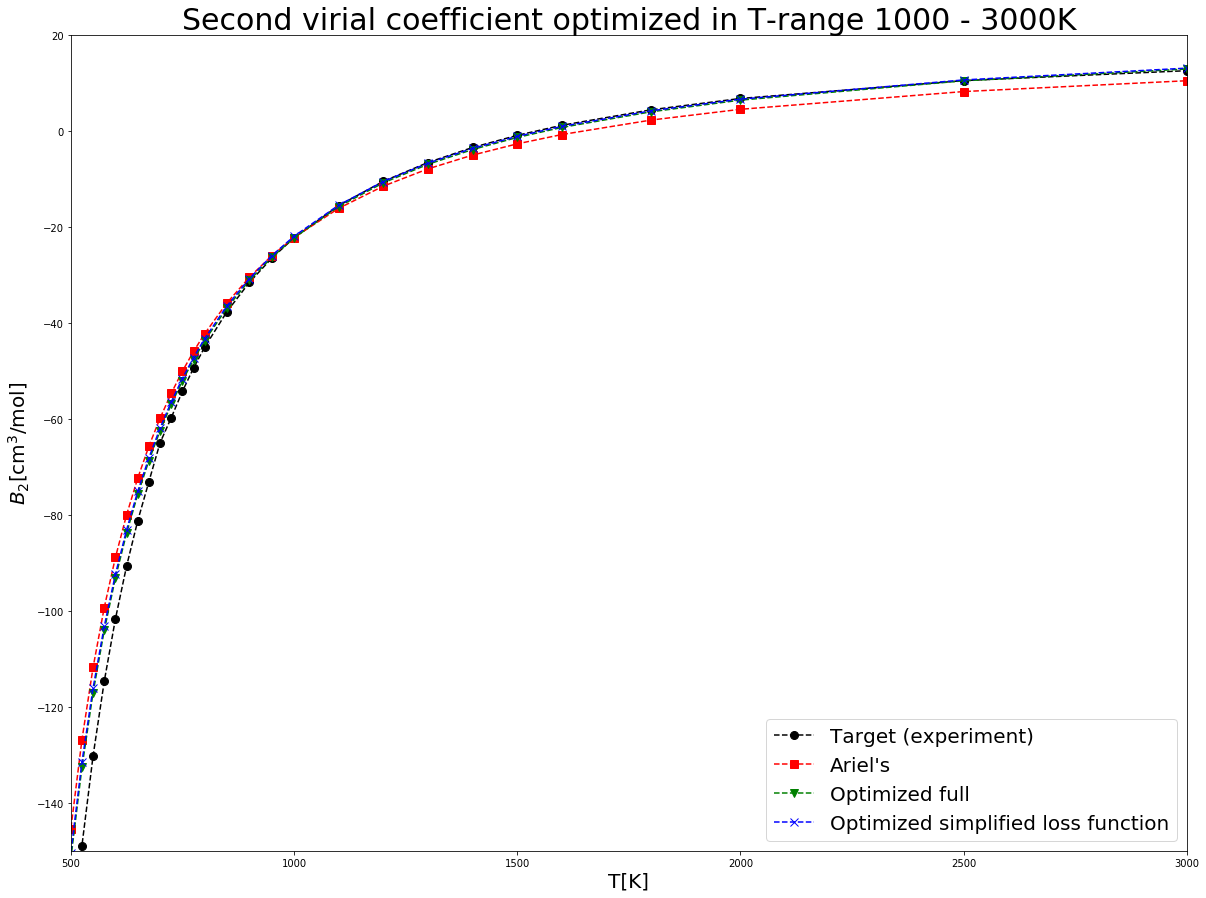

In [124]:
plt.figure(figsize=(20,15))
Temp = np.array(target_eos)[:,1]
plt.plot(Temp, np.array(target_eos)[:,2]*1e6, 'ko--', ms=8, label='Target (experiment)')
plt.plot(Temp, b2_start*1e6, 'rs--', ms=8, label='Ariel\'s')
plt.plot(Temp, b2_model*1e6, 'gv--', ms=8, label='Optimized full')
plt.plot(Temp, b2_b2opt*1e6, 'bx--', ms=8, label='Optimized simplified loss function')
#plt.plot(Temp, b2_dens*1e6, 'mx--', ms=8, label='Looks best')

plt.xlabel('T[K]', fontsize=20)
plt.ylabel('$B_2$[cm$^3$/mol]', fontsize=20)
plt.legend(fontsize=20)

plt.ylim(-150, 20)
plt.xlim(500,3000)
plt.title('Second virial coefficient optimized in T-range 1000 - 3000K', fontsize=30)

In [116]:
print(np.linspace(2.83, 4.0, 40))
print(np.linspace(352., 469., 40))

[2.83 2.86 2.89 2.92 2.95 2.98 3.01 3.04 3.07 3.1  3.13 3.16 3.19 3.22
 3.25 3.28 3.31 3.34 3.37 3.4  3.43 3.46 3.49 3.52 3.55 3.58 3.61 3.64
 3.67 3.7  3.73 3.76 3.79 3.82 3.85 3.88 3.91 3.94 3.97 4.  ]
[352. 355. 358. 361. 364. 367. 370. 373. 376. 379. 382. 385. 388. 391.
 394. 397. 400. 403. 406. 409. 412. 415. 418. 421. 424. 427. 430. 433.
 436. 439. 442. 445. 448. 451. 454. 457. 460. 463. 466. 469.]


In [120]:
sig_list = np.linspace(2.85, 3.35, 40)
eps_list = np.linspace(252., 369., 40)

n_sig = len(sig_list)
n_eps = len(eps_list)

s2_profiles = np.empty((n_sig, n_eps), dtype=float)
pars_profiles = np.empty((n_sig, n_eps, 2), dtype=float)
for i, j in product(range(n_sig), range(n_eps)):
    sig = sig_list[i]
    eps = eps_list[j]
    pars_in = np.array([sig, eps])
    #print(pars_in)
    s2 = loss_rho(pars_in, target_eos)
    #s2 = loss_b2(pars_in, target_eos)

    s2_profiles[i, j] = s2
    pars_profiles[i, j, :] = pars_in

[  3.11923077 270.        ]


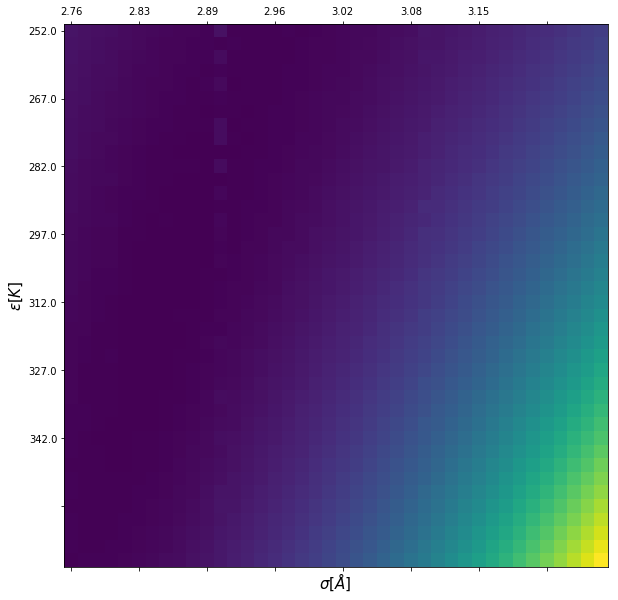

In [121]:
import matplotlib.ticker as ticker

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
im = axes.matshow(s2_profiles)
indices = np.unravel_index(np.argmin(s2_profiles, axis=None), s2_profiles.shape)
axes.xaxis.set_major_locator(ticker.MultipleLocator(5))
axes.yaxis.set_major_locator(ticker.MultipleLocator(5))
axes.set_xticklabels([str(round(v-0.15, 2)) for v in sig_list[::5]])
axes.set_yticklabels([str(round(v-15, 2)) for v in eps_list[::5]])

#axes.set_yticklabels(ticklabels)
axes.set_xlabel('$\sigma [\AA]$ ', fontsize=15)
axes.set_ylabel('$\epsilon [K]$', fontsize=15)
pars_optimal = pars_profiles[indices]
print(pars_optimal)
#axes.set_title('Total\n Optimal parameters: ' + str(params_dens), fontsize=20)

In [119]:
np.min(s2_profiles)

1.9175181180841945e-21